In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data_n100000_nf3_b1000b2000b3000_edge125_noiseless.mat


In [41]:
import matplotlib.pyplot as plt
import numpy as np          
from os.path import dirname, join as pjoin
import scipy.io as sio
import torch

from math import cos,sin

from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

In [42]:
mat_fname = "/kaggle/input/data_n100000_nf3_b1000b2000b3000_edge125_noiseless.mat"

In [43]:
mat_contents = sio.loadmat(mat_fname, spmatrix=False)

In [44]:
dwi_data = mat_contents['dwi']
voxt_directions = mat_contents['voxt']['directions']
voxt_ndir = mat_contents['voxt']['ndir']
print(dwi_data.shape, voxt_directions.shape, voxt_ndir.shape)
#voxt_directions = voxt_directions.T
#voxt_ndir = voxt_ndir.T
dwi_data.shape, voxt_directions.shape, voxt_ndir.shape

(100000, 271) (1, 100000) (1, 100000)


((100000, 271), (1, 100000), (1, 100000))

In [45]:
dwi_df = pd.DataFrame(dwi_data)
print(dwi_df.shape)
dwi_df.head()

(100000, 271)


,0,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
0,1.0,0.384153,0.418521,0.455972,0.341455,0.436808,0.368936,0.459862,0.372158,0.351873,...,0.301840,0.045344,0.200789,0.176308,0.247348,0.071571,0.167355,0.219863,0.319505,0.082791
1,1.0,0.395778,0.384606,0.216946,0.307236,0.560694,0.544845,0.506081,0.409586,0.440736,...,0.222927,0.006135,0.017991,0.211779,0.032504,0.361092,0.086021,0.179503,0.095435,0.060580
2,1.0,0.486848,0.395559,0.440019,0.484773,0.377528,0.528064,0.334176,0.548768,0.566366,...,0.463956,0.091876,0.117794,0.376275,0.030608,0.441554,0.105825,0.094855,0.051356,0.286201
3,1.0,0.412950,0.345664,0.169567,0.706696,0.529414,0.376036,0.715192,0.665584,0.432066,...,0.003567,0.030813,0.330944,0.191497,0.149600,0.025808,0.106044,0.210483,0.140951,0.383397
4,1.0,0.381064,0.537113,0.364683,0.485454,0.263963,0.530239,0.319479,0.550543,0.450314,...,0.065225,0.160541,0.171665,0.359451,0.364463,0.192081,0.117127,0.321770,0.152498,0.066113


In [46]:
dwi_df['voxt_directions'] = voxt_directions[0]
dwi_df['voxt_ndir'] = voxt_ndir[0]

In [47]:
dwi_df.head()

,0,1,2,3,4,5,6,7,8,9,...,263,264,265,266,267,268,269,270,voxt_directions,voxt_ndir
0,1.0,0.384153,0.418521,0.455972,0.341455,0.436808,0.368936,0.459862,0.372158,0.351873,...,0.200789,0.176308,0.247348,0.071571,0.167355,0.219863,0.319505,0.082791,"[[1.093523101619975, -1.0712505488597581], [1....",[[3]]
1,1.0,0.395778,0.384606,0.216946,0.307236,0.560694,0.544845,0.506081,0.409586,0.440736,...,0.017991,0.211779,0.032504,0.361092,0.086021,0.179503,0.095435,0.060580,"[[-2.702678926300885, -0.8255197339091209]]",[[1]]
2,1.0,0.486848,0.395559,0.440019,0.484773,0.377528,0.528064,0.334176,0.548768,0.566366,...,0.117794,0.376275,0.030608,0.441554,0.105825,0.094855,0.051356,0.286201,"[[-1.284640164282406, 0.10745114508583531], [0...",[[2]]
3,1.0,0.412950,0.345664,0.169567,0.706696,0.529414,0.376036,0.715192,0.665584,0.432066,...,0.330944,0.191497,0.149600,0.025808,0.106044,0.210483,0.140951,0.383397,"[[0.7855602789322647, -1.2172543959888724]]",[[1]]
4,1.0,0.381064,0.537113,0.364683,0.485454,0.263963,0.530239,0.319479,0.550543,0.450314,...,0.171665,0.359451,0.364463,0.192081,0.117127,0.321770,0.152498,0.066113,"[[-1.7427986708082914, 0.6527871588092062], [-...",[[2]]


In [48]:
dwi_df['voxt_directions'][99997][0][0]

-0.6029278783517174

In [49]:
trueX=[]
trueY=[]
trueZ=[]
for i in dwi_df['voxt_directions'] :
    el, az = i[0][0], i[0][1]
    trueX.append(cos(el)*cos(az))
    trueY.append(cos(el)*sin(az))
    trueZ.append(sin(el))
len(trueX), len(trueY), len(trueZ)

(100000, 100000, 100000)

In [50]:
dwi_df['trueX'] = trueX 
dwi_df['trueY'] = trueY
dwi_df['trueZ'] = trueZ 

In [51]:
#cleaning ndir
dwi_df['voxt_ndir'] = dwi_df['voxt_ndir'].apply(lambda x: x[0][0] if isinstance(x, np.ndarray) else x)
dwi_df.head()

# dwi_df.info()

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,voxt_directions,voxt_ndir,trueX,trueY,trueZ
0,1.0,0.384153,0.418521,0.455972,0.341455,0.436808,0.368936,0.459862,0.372158,0.351873,...,0.071571,0.167355,0.219863,0.319505,0.082791,"[[1.093523101619975, -1.0712505488597581], [1....",3,0.220045,-0.403225,0.888251
1,1.0,0.395778,0.384606,0.216946,0.307236,0.560694,0.544845,0.506081,0.409586,0.440736,...,0.361092,0.086021,0.179503,0.095435,0.060580,"[[-2.702678926300885, -0.8255197339091209]]",1,-0.613893,0.665242,-0.424956
2,1.0,0.486848,0.395559,0.440019,0.484773,0.377528,0.528064,0.334176,0.548768,0.566366,...,0.441554,0.105825,0.094855,0.051356,0.286201,"[[-1.284640164282406, 0.10745114508583531], [0...",2,0.280639,0.030272,-0.959336
3,1.0,0.412950,0.345664,0.169567,0.706696,0.529414,0.376036,0.715192,0.665584,0.432066,...,0.025808,0.106044,0.210483,0.140951,0.383397,"[[0.7855602789322647, -1.2172543959888724]]",1,0.244777,-0.663266,0.707221
4,1.0,0.381064,0.537113,0.364683,0.485454,0.263963,0.530239,0.319479,0.550543,0.450314,...,0.192081,0.117127,0.321770,0.152498,0.066113,"[[-1.7427986708082914, 0.6527871588092062], [-...",2,-0.135965,-0.103960,-0.985244


In [52]:
dwi_n1_df = dwi_df[dwi_df['voxt_ndir'] == 1].copy()
# print(dwi_n1_df.head())
# print(dwi_n1_df.info())

In [53]:
dwi_n1_df.columns

Index([                0,                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,                 8,
                       9,
       ...
                     266,               267,               268,
                     269,               270, 'voxt_directions',
             'voxt_ndir',           'trueX',           'trueY',
                 'trueZ'],
      dtype='object', length=276)

In [54]:
dwi_n1_df.shape

(33396, 276)

In [55]:
b_table = mat_contents['b_table']          # shape: (4, 271)
b_table.shape

(4, 271)

In [56]:
b_values = b_table[0, :]

# Get b-vectors (rows 1, 2, 3)
b_vectors = b_table[1:4, :].T # Transpose to get shape (num_directions, 3)

data = {
    'b_value': b_values,
    'b_vector_x': b_vectors[:, 0],
    'b_vector_y': b_vectors[:, 1],
    'b_vector_z': b_vectors[:, 2]
}

b_table_df = pd.DataFrame(data)

print("DataFrame created from b_table:")
print(b_table_df.head())

# print("\nDataFrame Info:")
# b_table_df.info()

# print("\nDataFrame Description:")
# print(b_table_df.describe())

DataFrame created from b_table:
       b_value  b_vector_x  b_vector_y  b_vector_z
0     0.000000    0.000000    0.000000    0.000000
1  1006.027789   -0.891291   -0.365323    0.268587
2  1006.027789   -0.378301    0.560127    0.736985
3  1006.027789   -0.048479    0.060345    0.997000
4  1006.027789    0.886465   -0.411969    0.210859


In [57]:
b_table_df.shape

(271, 4)

In [58]:

# Step 1: Extract DWI values from columns 1 to 270 (exclude b=0, which is column 0)
dwi_data = dwi_n1_df.loc[:, 1:270].astype(np.float32).values  # shape: [33396, 270]

# Step 2: Filter out b=0 row in b_table
b_table_filtered = b_table_df.iloc[1:].reset_index(drop=True)  # shape: [270, 4]

# Step 3: Get bvals and bvecs
bvals = b_table_filtered["b_value"].values.astype(np.float32)          # shape: [270]
bvecs = b_table_filtered[["b_vector_x", "b_vector_y", "b_vector_z"]].values.astype(np.float32)  # [270, 3]

# Step 4: Build per-voxel sequence of 270 vectors (each [dwi, bval, bx, by, bz])
def build_voxel_input(dwi_voxel):
    # shape: [270, 1] for signal, [270, 1] for bval, [270, 3] for bvecs
    return np.concatenate([
        dwi_voxel[:, None],          # [270, 1]
        bvals[:, None],              # [270, 1]
        bvecs                        # [270, 3]
    ], axis=1)  # → [270, 5]

# Step 5: Apply to all voxels
X = np.stack([build_voxel_input(row) for row in dwi_data])  # shape: [33396, 270, 5]

# Step 6: Extract target output
Y = dwi_n1_df[["trueX", "trueY", "trueZ"]].values.astype(np.float32)  # shape: [33396, 3]

print("Transformer input shape (X):", X.shape)  # (33396, 270, 5)
print("Target output shape (Y):", Y.shape)      # (33396, 3)


Transformer input shape (X): (33396, 270, 5)
Target output shape (Y): (33396, 3)


In [135]:
X[0]

array([[ 3.9577770e-01,  1.0060278e+03, -8.9129114e-01, -3.6532325e-01,
         2.6858708e-01],
       [ 3.8460565e-01,  1.0060278e+03, -3.7830105e-01,  5.6012654e-01,
         7.3698479e-01],
       [ 2.1694642e-01,  1.0060278e+03, -4.8478805e-02,  6.0344663e-02,
         9.9699968e-01],
       ...,
       [ 1.7950287e-01,  3.0180833e+03, -4.2910585e-01,  7.2636437e-01,
         5.3690130e-01],
       [ 9.5434986e-02,  3.0180833e+03,  5.8727717e-01,  7.8949475e-01,
        -1.7833547e-01],
       [ 6.0580168e-02,  3.0180833e+03,  7.2665203e-01, -5.9575582e-01,
         3.4212843e-01]], dtype=float32)

In [59]:
# X: [N, 270, 5]  
# Y: [N, 3]       # true directions (unit vectors)
# bvecs: [270, 3] # direction vectors only (already unit normed)

# Step 1: normalize bvecs and true directions (just in case)
bvecs_unit = bvecs / np.linalg.norm(bvecs, axis=1, keepdims=True)
Y_unit = Y / np.linalg.norm(Y, axis=1, keepdims=True)

# Step 2: compute dot product for all voxels
dot_products = np.matmul(Y_unit, bvecs_unit.T)  # [N, 270]

# Step 3: take the argmax across directions
labels = np.argmax(dot_products, axis=1).astype(np.int64)  # [N]

In [60]:
from torch.utils.data import DataLoader, Dataset

class DwiClassificationDataset(Dataset):
    def __init__(self, X, labels):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.labels[idx]

# Initialize dataset and loader
dataset = DwiClassificationDataset(X, labels)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [61]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=5, nhead=4, num_layers=2, num_classes=270):
        super().__init__()
        self.embed = nn.Linear(input_dim, 64)
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),           # [B, 64, 1]
            nn.Flatten(),                      # [B, 64]
            nn.Linear(64, num_classes)         # [B, 270]
        )

    def forward(self, x):
        # x: [B, 270, 5]
        x = self.embed(x)              # [B, 270, 64]
        x = x.permute(1, 0, 2)         # [270, B, 64] for transformer
        x = self.transformer(x)        # [270, B, 64]
        x = x.permute(1, 2, 0)         # [B, 64, 270]
        logits = self.cls_head(x)     # [B, 270]
        return logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
model = TransformerClassifier()
model = TransformerClassifier().to(device)
#model.load_state_dict(torch.load("classifier_model.pth", map_location=device))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
best_loss = float('inf')
for epoch in range(num_epochs):
    #print(f"epoch: {epoch}")
    total_loss = 0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        total_loss += loss.item() * X_batch.size(0)
        
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}: Train Loss = {avg_loss:.4f}")
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "classifier_model.pth")
        print("Saved best model.")

Epoch 0: Train Loss = 4.2573
Saved best model.
Epoch 1: Train Loss = 4.1961
Saved best model.
Epoch 2: Train Loss = 4.1922
Saved best model.
Epoch 3: Train Loss = 4.1897
Saved best model.
Epoch 4: Train Loss = 4.1887
Saved best model.
Epoch 5: Train Loss = 4.1877
Saved best model.
Epoch 6: Train Loss = 4.1858
Saved best model.
Epoch 7: Train Loss = 4.1844
Saved best model.
Epoch 8: Train Loss = 4.1829
Saved best model.
Epoch 9: Train Loss = 4.1822
Saved best model.
Epoch 10: Train Loss = 4.1818
Saved best model.
Epoch 11: Train Loss = 4.1808
Saved best model.
Epoch 12: Train Loss = 4.1801
Saved best model.
Epoch 13: Train Loss = 4.1800
Saved best model.
Epoch 14: Train Loss = 4.1796
Saved best model.
Epoch 15: Train Loss = 4.1790
Saved best model.
Epoch 16: Train Loss = 4.1791


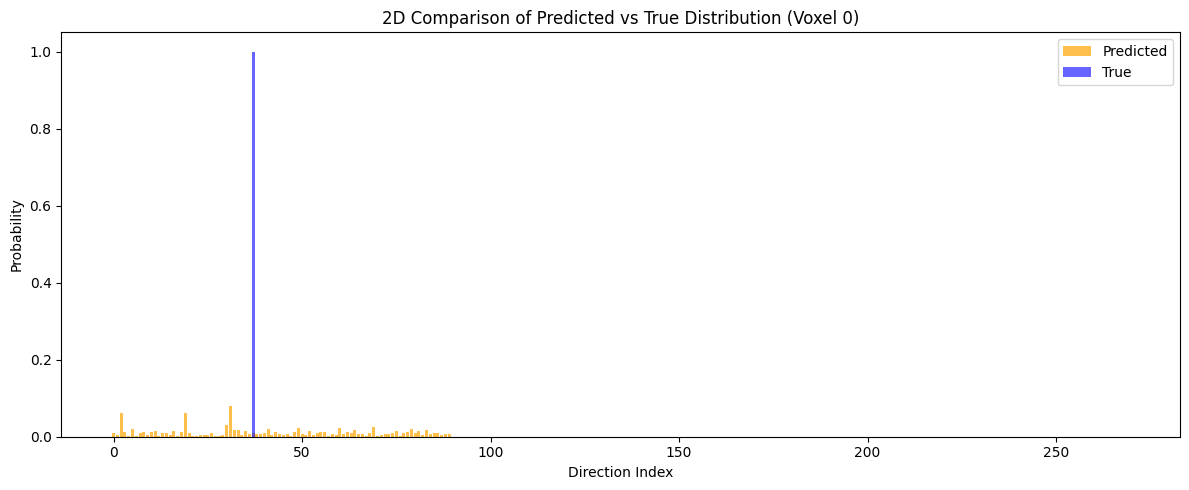

Error  Angle in radians: 1.0805640420321667
Error Angle in degrees: 61.911759102040044


In [132]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
probs = np.load("output_probabilities.npy")      # shape: [N, 270]
#print(len())
# Choose voxel
voxel_idx = 0
voxel_probs = probs[voxel_idx]  # [270]
true_label = labels[voxel_idx]  # scalar

# Reference one-hot distribution
ref_probs = np.zeros_like(voxel_probs)
ref_probs[true_label] = 1.0

# Plot 2D bar chart of predicted vs reference probabilities
plt.figure(figsize=(12, 5))
x = np.arange(len(voxel_probs))

plt.bar(x, voxel_probs, label="Predicted", alpha=0.7, color='orange')
plt.bar(x, ref_probs, label="True", alpha=0.6, color='blue')

plt.xlabel("Direction Index")
plt.ylabel("Probability")
plt.title(f"2D Comparison of Predicted vs True Distribution (Voxel {voxel_idx})")
plt.legend()
plt.tight_layout()
plt.savefig(f"voxel_{voxel_idx}_2d_prob_comparison.png")
plt.show()



voxel0_cuda = probs[voxel_idx]
voxel0_cpu = voxel0_cuda
voxel0_cpu_numpy = voxel0_cpu
#print(len(voxel0_cpu_numpy))
voxel0_maxdir = np.argmax(voxel0_cpu_numpy)
voxel0_maxdir

angle_rad=calculate_angular_error(X[voxel_idx][voxel0_maxdir][2:], Y[voxel_idx])
angle_deg = np.degrees(angle_rad)

print(f"Error  Angle in radians: {angle_rad}")
print(f"Error Angle in degrees: {angle_deg}")

In [126]:
voxel0_cuda = probs[0]
voxel0_cpu = voxel0_cuda.cpu()
voxel0_cpu_numpy = voxel0_cpu.numpy()
print(len(voxel0_cpu_numpy))
voxel0_maxdir = np.argmax(voxel0_cpu_numpy)
voxel0_maxdir

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [104]:
voxel0_cpu_numpy[31]

0.08054605

In [108]:
(X[0][31])

array([ 1.3493985e-01,  1.0060278e+03, -2.2037783e-01, -1.1440272e-01,
       -9.6868241e-01], dtype=float32)

In [117]:
X[0][31][2:]

array([-0.22037783, -0.11440272, -0.9686824 ], dtype=float32)

In [111]:
Y[0]

array([-0.61389345,  0.66524196, -0.4249564 ], dtype=float32)

In [121]:
angle_rad=calculate_angular_error(X[0][31][2:], Y[0])
angle_deg = np.degrees(angle_rad)

print(f"Angle in radians: {angle_rad}")
print(f"Angle in degrees: {angle_deg}")

Angle in radians: 1.0805640420321667
Angle in degrees: 61.911759102040044


In [116]:
def calculate_angular_error(vector_a, vector_b):

    dot_product = np.dot(vector_a, vector_b)
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)

    if magnitude_a == 0 or magnitude_b == 0:
        return 0.0  

    cosine_angle = dot_product / (magnitude_a * magnitude_b)

    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)

    angle_radians = np.arccos(cosine_angle)
    return angle_radians

vector1 = np.array([-2.2037783e-01,-1.1440272e-01,-9.6868241e-01])
vector2 = np.array([-0.61389345,  0.66524196, -0.4249564 ])
vector3 = -vector1
print(vector3)

angle_rad = calculate_angular_error(vector1, vector2)
angle_deg = np.degrees(angle_rad)

print(f"Angle in radians: {angle_rad}")
print(f"Angle in degrees: {angle_deg}")

[0.22037783 0.11440272 0.96868241]
Angle in radians: 1.0805640549967162
Angle in degrees: 61.91175984485401


In [65]:
model = TransformerClassifier()
model = TransformerClassifier().to(device)
model.load_state_dict(torch.load("classifier_model.pth", map_location=device))

<All keys matched successfully>

In [66]:
model = TransformerClassifier().to(device)
model.load_state_dict(torch.load("classifier_model.pth", map_location=device))
model.eval()

TransformerClassifier(
  (embed): Linear(in_features=5, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (cls_head): Sequential(
    (0): AdaptiveAvgPool1d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=64, out_features=270, bias=True)
  )
)

In [67]:
loader = DataLoader(DwiClassificationDataset(X, labels), batch_size=256)
all_preds = []
with torch.no_grad():
    for xb, _ in loader:
        xb = xb.to(device)
        logits = model(xb)
        pred_idx = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(pred_idx)

pred_indices = np.concatenate(all_preds)         # [N]
pred_dirs = bvecs[pred_indices]                  # [N, 3]
Y_unit = Y / np.linalg.norm(Y, axis=1, keepdims=True)
pred_unit = pred_dirs / np.linalg.norm(pred_dirs, axis=1, keepdims=True)

dot = np.clip(np.sum(Y_unit * pred_unit, axis=1), -1.0, 1.0)
angles = np.degrees(np.arccos(dot))

print(f"Mean Angular Error: {angles.mean():.2f}°")
print(f"Median Angular Error: {np.median(angles):.2f}°")

Mean Angular Error: 90.05°
Median Angular Error: 90.37°


In [85]:
loader = DataLoader(DwiClassificationDataset(X, labels), batch_size=256)
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)  # [B, 270]
        probs = torch.softmax(logits, dim=1)  # [B, 270]
        pred_idx = torch.argmax(probs, dim=1).cpu().numpy()

        all_preds.append(pred_idx)
        all_labels.append(yb.numpy())
        all_probs.append(probs.cpu().numpy())

pred_indices = np.concatenate(all_preds)         # [N]
true_indices = np.concatenate(all_labels)        # [N]
prob_distributions = np.concatenate(all_probs)   # [N, 270]
pred_dirs = bvecs[pred_indices]                  # [N, 3]
Y_unit = Y / np.linalg.norm(Y, axis=1, keepdims=True)
pred_unit = pred_dirs / np.linalg.norm(pred_dirs, axis=1, keepdims=True)

dot = np.clip(np.sum(Y_unit * pred_unit, axis=1), -1.0, 1.0)
angles = np.degrees(np.arccos(dot))

print(f"Mean Angular Error: {angles.mean():.2f}°")
print(f"Median Angular Error: {np.median(angles):.2f}°")
print(f"90th Percentile Angular Error: {np.percentile(angles, 90):.2f}°")

# Save softmax probabilities
np.save("output_probabilities.npy", prob_distributions)

# Histogram of angular errors
plt.figure(figsize=(8, 5))
plt.hist(angles, bins=50, color='skyblue', edgecolor='black')
plt.title("Angular Error Distribution")
plt.xlabel("Angular Error (degrees)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("angular_error_histogram.png")
plt.close()


Mean Angular Error: 90.05°
Median Angular Error: 90.37°
90th Percentile Angular Error: 159.84°


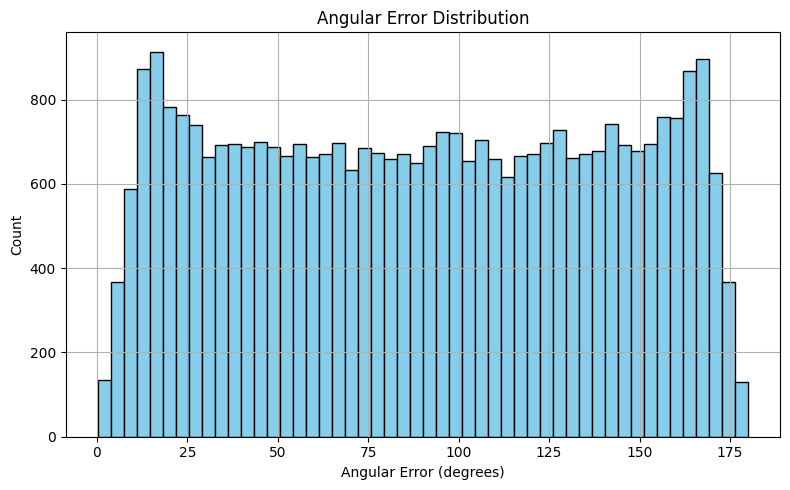

In [34]:
# Histogram of angular errors
plt.figure(figsize=(8, 5))
plt.hist(angles, bins=50, color='skyblue', edgecolor='black')
plt.title("Angular Error Distribution")
plt.xlabel("Angular Error (degrees)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
# plt.savefig("angular_error_histogram.png")
# plt.close()



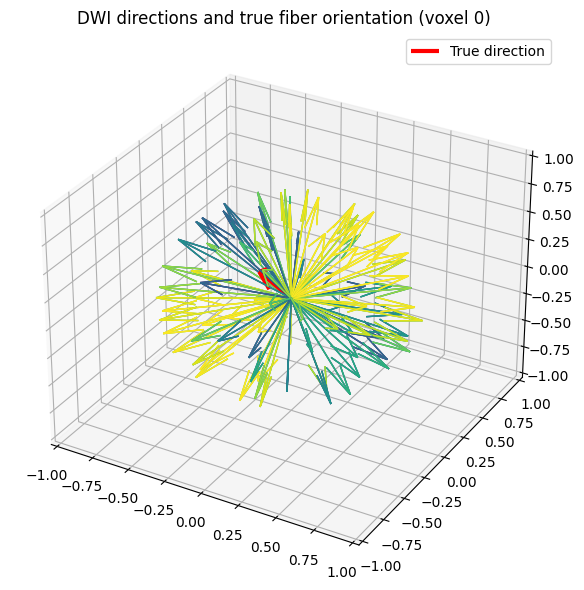

In [21]:
# Pick a voxel index to visualize
voxel_idx = 0
voxel_data = X[voxel_idx]  # shape: [270, 5]
true_dir = Y[voxel_idx]    # shape: [3]

# Extract signal and b-vectors
signals = voxel_data[:, 0]
bvecs = voxel_data[:, 2:5]  # shape: [270, 3]

# Normalize bvecs
bvecs = bvecs / np.linalg.norm(bvecs, axis=1, keepdims=True)

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# Color by signal strength (lower signal = more attenuation = darker)
norm_signals = (signals - signals.min()) / (signals.max() - signals.min())
colors = plt.cm.viridis(1 - norm_signals)  # darker = lower signal

# Plot b-vectors as arrows
for i in range(bvecs.shape[0]):
    ax.quiver(0, 0, 0, bvecs[i, 0], bvecs[i, 1], bvecs[i, 2],
              color=colors[i], length=0.8, normalize=True, linewidth=1)

# Plot true direction in red
ax.quiver(0, 0, 0, true_dir[0], true_dir[1], true_dir[2],
          color='red', length=1.0, linewidth=3, label="True direction")

ax.set_title("DWI directions and true fiber orientation (voxel 0)")
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.legend()
plt.tight_layout()
plt.show()

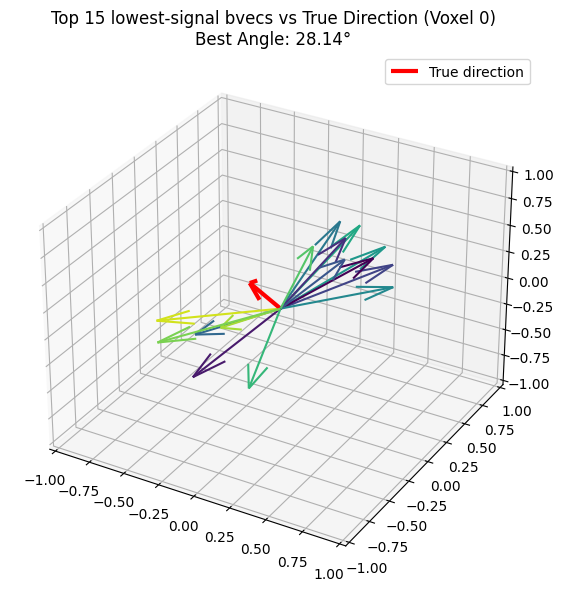

In [22]:
voxel_idx = 0

voxel_data = X[voxel_idx]
true_dir = Y[voxel_idx]
signals = voxel_data[:, 0]
bvecs = voxel_data[:, 2:5]
bvecs = bvecs / np.linalg.norm(bvecs, axis=1, keepdims=True)

# Sort by signal intensity (ascending = more attenuated)
sorted_idx = np.argsort(signals)[:15]  # top 15 lowest signals
top_bvecs = bvecs[sorted_idx]
top_signals = signals[sorted_idx]

# Compute angle to true direction
top_dot = np.dot(top_bvecs, true_dir)
top_angle = np.arccos(np.clip(top_dot, -1.0, 1.0)) * 180 / np.pi
best_angle = np.min(top_angle)

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# Plot top attenuated directions
for i in range(len(top_bvecs)):
    ax.quiver(0, 0, 0, top_bvecs[i, 0], top_bvecs[i, 1], top_bvecs[i, 2],
              color=plt.cm.viridis(i / 15), length=0.8, normalize=True)

# Plot true direction
ax.quiver(0, 0, 0, true_dir[0], true_dir[1], true_dir[2],
          color='red', linewidth=3, label="True direction")

ax.set_title(f"Top 15 lowest-signal bvecs vs True Direction (Voxel {voxel_idx})\nBest Angle: {best_angle:.2f}°")
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.legend()
plt.tight_layout()
plt.show()

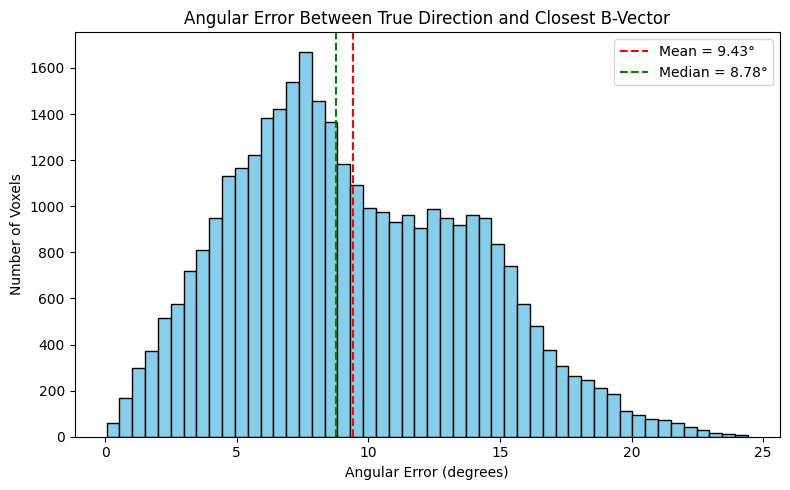

(9.430414, 8.7836, 0.055952907, 24.423801)

In [23]:
bvecs = X[0, :, 2:5]             # [270, 3]
bvecs = bvecs / np.linalg.norm(bvecs, axis=1, keepdims=True)

# Normalize true directions
Y_unit = Y / np.linalg.norm(Y, axis=1, keepdims=True)  # [N, 3]

# Compute dot products and find best cosine alignment
dot_products = np.dot(Y_unit, bvecs.T)  # [N, 270]
max_dot = np.max(dot_products, axis=1)  # best cosine similarity per voxel

# Convert to angular error in degrees
angles = np.arccos(np.clip(max_dot, -1.0, 1.0)) * 180 / np.pi

# Summary stats
mean_angle = np.mean(angles)
median_angle = np.median(angles)
min_angle = np.min(angles)
max_angle = np.max(angles)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(angles, bins=50, color='skyblue', edgecolor='black')
plt.title("Angular Error Between True Direction and Closest B-Vector")
plt.xlabel("Angular Error (degrees)")
plt.ylabel("Number of Voxels")
plt.axvline(mean_angle, color='red', linestyle='--', label=f"Mean = {mean_angle:.2f}°")
plt.axvline(median_angle, color='green', linestyle='--', label=f"Median = {median_angle:.2f}°")
plt.legend()
plt.tight_layout()
plt.show()

(mean_angle, median_angle, min_angle, max_angle)

In [24]:
bvecs = X[0, :, 2:5]  # [270, 3]
bvecs = bvecs / np.linalg.norm(bvecs, axis=1, keepdims=True)

# Extract true direction and normalize
true_dir = Y[0]
true_dir = true_dir / np.linalg.norm(true_dir)

# Compute cosine similarity with all bvecs
cos_sim = bvecs @ true_dir  # shape: [270]

# Find the most aligned bvec
best_idx = np.argmax(cos_sim)
best_bvec = bvecs[best_idx]

# Compute angular error in degrees
angle_rad = np.arccos(np.clip(np.dot(best_bvec, true_dir), -1.0, 1.0))
angle_deg = np.degrees(angle_rad)

# Print results
print(f"Voxel 0: Best matching bvec index = {best_idx}")
print(f"Angular error = {angle_deg:.2f}°")

Voxel 0: Best matching bvec index = 37
Angular error = 13.21°


270
540
Voxel 0: Best matching bvec index = 320
Angular error = 6.99°


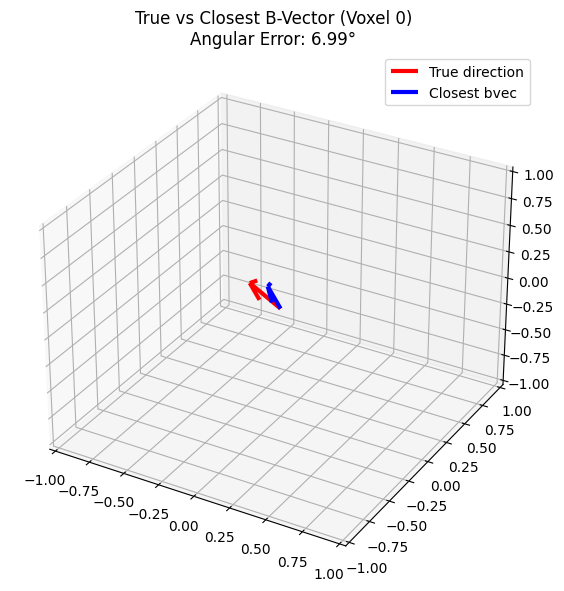

In [33]:
voxel_idx = 0

# Extract bvecs and normalize
bvecs = X[voxel_idx, :, 2:5]
print(len(bvecs))
bvecs = np.append(bvecs,-bvecs, axis=0)
print(len(bvecs))
bvecs = bvecs / np.linalg.norm(bvecs, axis=1, keepdims=True)

# Extract true direction and normalize
true_dir = Y[voxel_idx]
true_dir = true_dir / np.linalg.norm(true_dir)

# Cosine similarity with all bvecs
cos_sim = bvecs @ true_dir
best_idx = np.argmax(cos_sim)
best_bvec = bvecs[best_idx]

# Angular error
angle_rad = np.arccos(np.clip(np.dot(best_bvec, true_dir), -1.0, 1.0))
angle_deg = np.degrees(angle_rad)

# Print results
print(f"Voxel {voxel_idx}: Best matching bvec index = {best_idx}")
print(f"Angular error = {angle_deg:.2f}°")

# Plot true direction and best bvec
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")

ax.quiver(0, 0, 0, true_dir[0], true_dir[1], true_dir[2],
          color='red', linewidth=3, label='True direction')
ax.quiver(0, 0, 0, best_bvec[0], best_bvec[1], best_bvec[2],
          color='blue', linewidth=3, label='Closest bvec')

ax.set_title(f"True vs Closest B-Vector (Voxel {voxel_idx})\nAngular Error: {angle_deg:.2f}°")
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.legend()
plt.tight_layout()
plt.show()

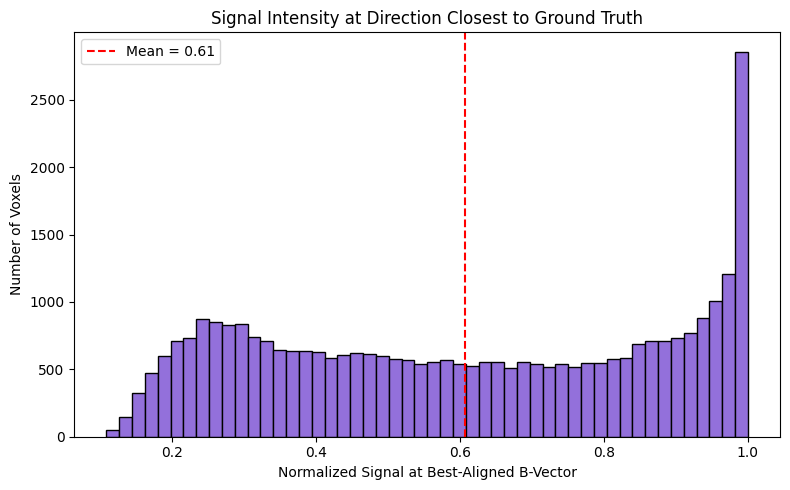

(0.6065673, 0.6049967)

In [26]:
#2
Y_unit = Y / np.linalg.norm(Y, axis=1, keepdims=True)  # [N, 3]

# Extract bvecs from any voxel (they are shared across all voxels)
bvecs = X[0, :, 2:5]  # [270, 3]
bvecs = bvecs / np.linalg.norm(bvecs, axis=1, keepdims=True)

# Step 1 & 2: Compute dot product with each bvec for every voxel
dot_products = Y_unit @ bvecs.T  # [N, 270]
best_bvec_idx = np.argmax(dot_products, axis=1)  # [N]
best_alignment = np.max(dot_products, axis=1)    # [N]

# Step 3: For each voxel, get the signal at the best-aligned bvec
N = X.shape[0]
signals = np.array([X[i, best_bvec_idx[i], 0] for i in range(N)])  # signal at best-aligned bvec

# Normalize signal intensity per voxel (to assess attenuation)
min_signal = X[:, :, 0].min(axis=1)
max_signal = X[:, :, 0].max(axis=1)
normalized_signal = (signals - min_signal) / (max_signal - min_signal)

# Plot signal rank vs alignment
plt.figure(figsize=(8, 5))
plt.hist(normalized_signal, bins=50, color='mediumpurple', edgecolor='black')
plt.xlabel("Normalized Signal at Best-Aligned B-Vector")
plt.ylabel("Number of Voxels")
plt.title("Signal Intensity at Direction Closest to Ground Truth")
plt.axvline(np.mean(normalized_signal), color='red', linestyle='--', label=f"Mean = {np.mean(normalized_signal):.2f}")
plt.legend()
plt.tight_layout()
plt.show()

np.mean(normalized_signal), np.median(normalized_signal)

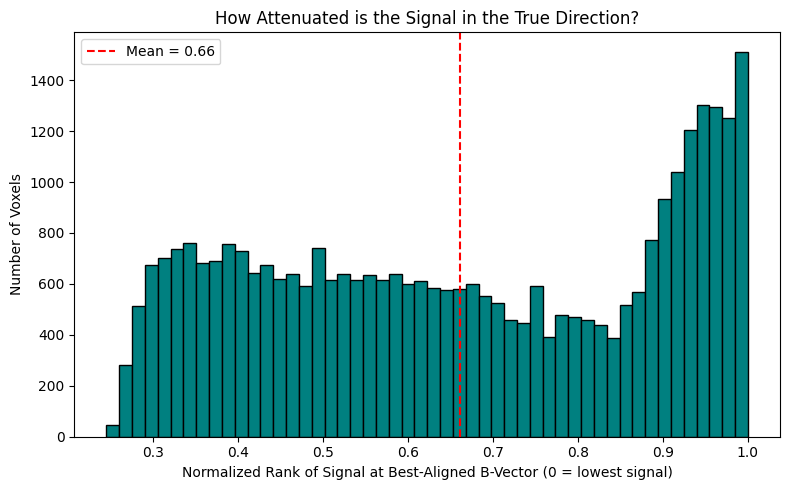

(0.6607970324340426, 0.654275092936803)

In [27]:
# Step 3: Rank all 270 signals per voxel and get rank of signal at best-aligned bvec

# Sort signals per voxel and get ranks
signal_values = X[:, :, 0]  # [N, 270]
sorted_indices = np.argsort(signal_values, axis=1)  # [N, 270]

# Build a rank map: for each (voxel, bvec), what is the rank of that bvec's signal?
rank_map = np.zeros_like(sorted_indices)
for i in range(sorted_indices.shape[0]):
    rank_map[i, sorted_indices[i]] = np.arange(270)

# For each voxel, get rank of signal at best-aligned bvec
signal_ranks = rank_map[np.arange(X.shape[0]), best_bvec_idx]  # [N]

# Normalize rank to [0, 1]
normalized_ranks = signal_ranks / 269.0

# Plot histogram of ranks
plt.figure(figsize=(8, 5))
plt.hist(normalized_ranks, bins=50, color='teal', edgecolor='black')
plt.xlabel("Normalized Rank of Signal at Best-Aligned B-Vector (0 = lowest signal)")
plt.ylabel("Number of Voxels")
plt.title("How Attenuated is the Signal in the True Direction?")
plt.axvline(np.mean(normalized_ranks), color='red', linestyle='--', label=f"Mean = {np.mean(normalized_ranks):.2f}")
plt.legend()
plt.tight_layout()
plt.show()

np.mean(normalized_ranks), np.median(normalized_ranks)

In [36]:
# train_transformer_cpu.py

# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, Dataset

# # Load preprocessed numpy data
# X = np.load('X.npy')  # shape: [N, 270, 5]
# Y = np.load('Y.npy')  # shape: [N, 3]

# Torch dataset
class DWIDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Transformer model
class DirectionRegressor(nn.Module):
    def __init__(self, input_dim=5, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=128, dropout=0.1)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )

    def forward(self, x):  # x: [B, 270, 5]
        x = self.embedding(x)  # [B, 270, d_model]
        x = x.permute(1, 0, 2)  # [270, B, d_model]
        x = self.encoder(x)  # [270, B, d_model]
        x = x.mean(dim=0)  # [B, d_model]
        x = self.head(x)  # [B, 3]
        return F.normalize(x, dim=1)  # unit vector

# Loss: angular error
def angular_loss(pred, target):
    cos_sim = F.cosine_similarity(pred, target, dim=1)
    cos_sim = torch.clamp(cos_sim, -1.0, 1.0)
    return torch.mean(torch.acos(cos_sim))  # radians

# Training loop
def train_model(dataset):
    #dataset = DWIDataset(X, Y)
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

    model = DirectionRegressor()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(1, 21):
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = angular_loss(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate
        model.eval()
        with torch.no_grad():
            pred = model(torch.tensor(X, dtype=torch.float32))
            val_loss = angular_loss(pred, torch.tensor(Y)).item()
            deg = np.degrees(val_loss)
            print(f"Epoch {epoch}: Val Loss = {val_loss:.4f} rad, Angular Error = {deg:.2f}°")

        # Save model
        if epoch == 1 or deg < best_deg:
            best_deg = deg
            torch.save(model.state_dict(), "best_model.pth")
            print("Saved best model.")

In [ ]:
train_model(dataset)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [31]:
class DWIDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [34]:
dataset = DWIDataset(X, Y)

val_frac = 0.1
val_size = int(len(dataset) * val_frac)
train_size = len(dataset) - val_size

train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

In [23]:
class DWITransformer(nn.Module):
    def __init__(self, input_dim=5, emb_dim=64, n_heads=4, n_layers=4, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=n_heads, dim_feedforward=256,
            dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        x = self.embedding(x)         # [B, 270, 5] → [B, 270, emb]
        x = self.encoder(x)           # [B, 270, emb]
        x = x.mean(dim=1)             # [B, emb] (mean pooling)
        x = self.mlp(x)               # [B, 3]
        return F.normalize(x, dim=1)  # unit vector

In [24]:
def cosine_similarity_loss(pred, target):
    return 1 - F.cosine_similarity(pred, target, dim=1).mean()

def angular_error_deg(pred, target):
    dot = (F.normalize(pred, dim=1) * F.normalize(target, dim=1)).sum(dim=1).clamp(-1.0, 1.0)
    return torch.acos(dot) * (180 / torch.pi)

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DWITransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_loss = float('inf')

for epoch in range(50):
    model.train()
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = cosine_similarity_loss(preds, Y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_angle = 0
        count = 0
        for X_val, Y_val in val_loader:
            X_val, Y_val = X_val.to(device), Y_val.to(device)
            preds = model(X_val)
            val_loss = cosine_similarity_loss(preds, Y_val)
            angle_error = angular_error_deg(preds, Y_val).mean()

            total_loss += val_loss.item() * X_val.size(0)
            total_angle += angle_error.item() * X_val.size(0)
            count += X_val.size(0)

        avg_loss = total_loss / count
        avg_angle = total_angle / count
        print(f"Epoch {epoch+1} | Val Loss: {avg_loss:.4f} | Mean Angular Error: {avg_angle:.2f}°")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), "best_model.pt")
            print("Saved best model.")

KeyboardInterrupt: 

In [ ]:
# Before training
from numpy.linalg import norm
print(np.mean(np.linalg.norm(Y, axis=1)))  # should be very close to 1.0

In [ ]:
for X_batch, Y_batch in val_loader:
    preds = model(X_batch.to(device)).cpu().detach().numpy()
    print("Sample pred:", preds[0], "GT:", Y_batch[0].numpy())
    break

In [ ]:
print("DWI stats:", np.min(X), np.max(X), np.mean(X))


In [ ]:
small_loader = DataLoader(torch.utils.data.Subset(dataset, range(64)), batch_size=16)

In [ ]:
small_loader

In [27]:
def hybrid_loss(pred, target):
    pred_norm = F.normalize(pred, dim=1)
    target_norm = F.normalize(target, dim=1)
    cosine = 1 - F.cosine_similarity(pred_norm, target_norm, dim=1)
    l2 = F.mse_loss(pred_norm, target_norm, reduction='none').mean(dim=1)
    return (cosine + l2).mean()

In [28]:
# -----------------------------
# Transformer Model
# -----------------------------
class DWITransformer(nn.Module):
    def __init__(self, input_dim=5, emb_dim=64, n_heads=4, n_layers=4, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=n_heads, dim_feedforward=256,
            dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 3)  # No ReLU here
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = x.mean(dim=1)
        x = self.mlp(x)
        return F.normalize(x, dim=1)

In [29]:
# -----------------------------
# MLP Baseline Model
# -----------------------------
class MLPBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(270 * 5, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        return F.normalize(self.mlp(x), dim=1)

In [30]:
# -----------------------------
# Hybrid Loss & Angular Error
# -----------------------------
def hybrid_loss(pred, target):
    pred_norm = F.normalize(pred, dim=1)
    target_norm = F.normalize(target, dim=1)
    cosine = 1 - F.cosine_similarity(pred_norm, target_norm, dim=1)
    l2 = F.mse_loss(pred_norm, target_norm, reduction='none').mean(dim=1)
    return (cosine + l2).mean()

def angular_error_deg(pred, target):
    dot = (F.normalize(pred, dim=1) * F.normalize(target, dim=1)).sum(dim=1).clamp(-1.0, 1.0)
    return torch.acos(dot) * (180 / torch.pi)

In [35]:
dataset

In [43]:
def train_model(dataset, epochs=20, batch_size=64, save_path="best_model.pt", use_mlp=False, overfit_test=False):
    #dataset = DWIDataset(X_path, Y_path)

    if overfit_test:
        dataset = torch.utils.data.Subset(dataset, range(64))
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    else:
        val_size = int(0.1 * len(dataset))
        train_size = len(dataset) - val_size
        train_set, val_set = random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = MLPBaseline() if use_mlp else DWITransformer()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    best_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = hybrid_loss(preds, Y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss, val_angle = 0, 0
        count = 0
        with torch.no_grad():
            for X_val, Y_val in val_loader:
                X_val, Y_val = X_val.to(device), Y_val.to(device)
                preds = model(X_val)
                loss = hybrid_loss(preds, Y_val)
                angle_error = angular_error_deg(preds, Y_val).mean()
                val_loss += loss.item() * X_val.size(0)
                val_angle += angle_error.item() * X_val.size(0)
                count += X_val.size(0)

        avg_loss = val_loss / count
        avg_angle = val_angle / count
        print(f"Epoch {epoch+1}: Val Loss = {avg_loss:.4f}, Angular Error = {avg_angle:.2f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), save_path)
            print("Saved best model.")

In [44]:
train_model(dataset, use_mlp=True, overfit_test=True)

Epoch 1: Val Loss = 1.5449, Angular Error = 85.01
Saved best model.
Epoch 2: Val Loss = 1.4833, Angular Error = 82.75
Saved best model.
Epoch 3: Val Loss = 1.4614, Angular Error = 81.93
Saved best model.
Epoch 4: Val Loss = 1.4535, Angular Error = 81.40
Saved best model.
Epoch 5: Val Loss = 1.4510, Angular Error = 81.01
Saved best model.
Epoch 6: Val Loss = 1.4502, Angular Error = 80.77
Saved best model.
Epoch 7: Val Loss = 1.4503, Angular Error = 80.59
Epoch 8: Val Loss = 1.4506, Angular Error = 80.43
Epoch 9: Val Loss = 1.4509, Angular Error = 80.32
Epoch 10: Val Loss = 1.4513, Angular Error = 80.24
Epoch 11: Val Loss = 1.4515, Angular Error = 80.19
Epoch 12: Val Loss = 1.4517, Angular Error = 80.16
Epoch 13: Val Loss = 1.4518, Angular Error = 80.15
Epoch 14: Val Loss = 1.4518, Angular Error = 80.14
Epoch 15: Val Loss = 1.4517, Angular Error = 80.15
Epoch 16: Val Loss = 1.4516, Angular Error = 80.17
Epoch 17: Val Loss = 1.4515, Angular Error = 80.19
Epoch 18: Val Loss = 1.4513, Angul

In [41]:
train_model(dataset, use_mlp=True, overfit_test=False)

Epoch 1: Val Loss = 1.6545, Angular Error = 89.61
Saved best model.
Epoch 2: Val Loss = 1.6591, Angular Error = 89.67
Epoch 3: Val Loss = 1.6632, Angular Error = 89.85
Epoch 4: Val Loss = 1.6659, Angular Error = 89.96
Epoch 5: Val Loss = 1.6666, Angular Error = 89.97
Epoch 6: Val Loss = 1.6705, Angular Error = 90.13
Epoch 7: Val Loss = 1.6720, Angular Error = 90.20
Epoch 8: Val Loss = 1.6719, Angular Error = 90.18
Epoch 9: Val Loss = 1.6741, Angular Error = 90.28
Epoch 10: Val Loss = 1.6766, Angular Error = 90.41
Epoch 11: Val Loss = 1.6765, Angular Error = 90.38
Epoch 12: Val Loss = 1.6781, Angular Error = 90.45
Epoch 13: Val Loss = 1.6794, Angular Error = 90.50
Epoch 14: Val Loss = 1.6812, Angular Error = 90.56
Epoch 15: Val Loss = 1.6835, Angular Error = 90.67
Epoch 16: Val Loss = 1.6834, Angular Error = 90.65
Epoch 17: Val Loss = 1.6832, Angular Error = 90.63
Epoch 18: Val Loss = 1.6807, Angular Error = 90.50
Epoch 19: Val Loss = 1.6828, Angular Error = 90.60
Epoch 20: Val Loss = 1

In [38]:
train_model(dataset, use_mlp=False, overfit_test=True)

Epoch 1: Val Loss = 1.7740, Angular Error = 94.41
Saved best model.
Epoch 2: Val Loss = 1.7577, Angular Error = 93.91
Saved best model.
Epoch 3: Val Loss = 1.7339, Angular Error = 93.09
Saved best model.
Epoch 4: Val Loss = 1.7074, Angular Error = 92.01
Saved best model.
Epoch 5: Val Loss = 1.6751, Angular Error = 90.59
Saved best model.
Epoch 6: Val Loss = 1.6350, Angular Error = 88.89
Saved best model.
Epoch 7: Val Loss = 1.5925, Angular Error = 87.16
Saved best model.
Epoch 8: Val Loss = 1.5554, Angular Error = 85.28
Saved best model.
Epoch 9: Val Loss = 1.5221, Angular Error = 83.45
Saved best model.
Epoch 10: Val Loss = 1.4969, Angular Error = 82.12
Saved best model.
Epoch 11: Val Loss = 1.4786, Angular Error = 81.22
Saved best model.
Epoch 12: Val Loss = 1.4661, Angular Error = 80.51
Saved best model.
Epoch 13: Val Loss = 1.4592, Angular Error = 80.42
Saved best model.
Epoch 14: Val Loss = 1.4560, Angular Error = 80.63
Saved best model.
Epoch 15: Val Loss = 1.4547, Angular Error 

In [45]:
# Check first voxel input/target
print("Sample DWI:", X[0][:5])  # First 5 directions
print("Target (trueX, Y, Z):", Y[0])

Sample DWI: [[ 3.9577770e-01  1.0060278e+03 -8.9129114e-01 -3.6532325e-01
   2.6858708e-01]
 [ 3.8460565e-01  1.0060278e+03 -3.7830105e-01  5.6012654e-01
   7.3698479e-01]
 [ 2.1694642e-01  1.0060278e+03 -4.8478805e-02  6.0344663e-02
   9.9699968e-01]
 [ 3.0723605e-01  1.0060278e+03  8.8646483e-01 -4.1196913e-01
   2.1085896e-01]
 [ 5.6069446e-01  1.0060278e+03 -3.5164222e-02 -9.8432845e-01
   1.7280343e-01]]
Target (trueX, Y, Z): [-0.61389345  0.66524196 -0.4249564 ]


In [46]:
def predict_naive(X):
    signals = X[:, :, 0]  # DWI signal
    min_indices = np.argmin(signals, axis=1)
    bvecs = X[0, :, 2:]   # assumes same bvecs for all
    preds = bvecs[min_indices]
    preds = preds / np.linalg.norm(preds, axis=1, keepdims=True)
    return preds

In [49]:
# Ensure Y is normalized
Y = Y / np.linalg.norm(Y, axis=1, keepdims=True)

# Naive prediction: pick bvec of lowest signal
signals = X[:, :, 0]  # DWI values
min_indices = np.argmin(signals, axis=1)

# Extract the corresponding bvecs for each voxel
preds = np.array([X[i, j, 2:] for i, j in enumerate(min_indices)])  # shape: [N, 3]
preds = preds / np.linalg.norm(preds, axis=1, keepdims=True)

# Angular error
dot = np.sum(preds * Y, axis=1).clip(-1.0, 1.0)
angular_errors = np.arccos(dot) * (180 / np.pi)

print("Naive baseline mean angular error:", angular_errors.mean())

Naive baseline mean angular error: 91.08471
